In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from prettytable import PrettyTable

In [2]:
# Reading pre-processed dataset
data = pd.read_csv('final_data.csv')
data.dropna(inplace=True)

In [3]:
data.shape

(364156, 11)

In [4]:
data.sort_values(by='Time',ascending=True, inplace=True)

In [5]:
data.reset_index(drop=True, inplace=True)

In [6]:
sampled_data = data.loc[:]
sampled_data.shape

(364156, 11)

In [7]:
sampled_data['Score'].replace('positive','1',inplace=True)
sampled_data['Score'].replace('negative','0', inplace=True)

In [8]:
sampled_data['Score'].value_counts()

1    307051
0     57105
Name: Score, dtype: int64

In [9]:
X = sampled_data['CleanedText']
y = sampled_data['Score']

In [10]:
# Splitting into (70:30) : ( Train+CV : Test) 
X_train = X[:250000]
y_train = y[:250000]
X_test = X[250000:]
y_test = y[250000:]

In [93]:
# This function is for hyper parameter (alpha) tuning which uses F1 score for 5-fold Cross Validation and returns the optimum values
def apply_NB(X_train, y_train):
    """accepts X_train, y_train and returns optimum alpha"""
    alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    
    cv_scores=[]
    for alpha in alpha_list:
        scores = cross_val_score(MultinomialNB(alpha=alpha), X_train, y_train, scoring= make_scorer(f1_score, average='weighted'), cv=5)
        cv_scores.append(scores.mean())
        print("ALPHA : %f , Score : %f" % (alpha,scores.mean()))
    
    op_index = cv_scores.index(max(cv_scores))
    op_alpha = alpha_list[op_index]
    print("Optimum Alpha",op_alpha)
    print(plt.plot(alpha_list,cv_scores,marker='o',linestyle="dashed"))
    return op_alpha


def optimal_NB(X_train, X_test, y_train, op_alpha, count_vect):
    """returns prediction list and the optimal Naive Bayes model trained by using the optimal alpha value"""
    op_NB = MultinomialNB(alpha=op_alpha)
    op_NB.fit(X_train,y_train)
    pred = op_NB.predict(X_test)
    
    
    neg_class_prob_sorted =op_NB.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted =op_NB.feature_log_prob_[1, :].argsort()

    print("Negative Class Top Features:")
    print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
    print("*"*20)
    print("Positive Class Top Features:")
    print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-10:]))
    return pred,op_NB

def gen_confusion_matrix(y_test,pred):
    """Prints the confusion matrix"""
    print(sns.heatmap(confusion_matrix(y_test,pred),cmap="viridis",fmt='g', annot=True))
    
def gen_scores(y_test, pred):
    """Displays confusion matrix, Precision, Recall, F1 scores and accuracy values in a summarized table format"""
    gen_confusion_matrix(y_test,pred)
    pre = np.round(precision_score(y_test,pred,average='weighted'),4)
    recall = np.round(recall_score(y_test,pred,average='weighted'),4)
    f1 = np.round(f1_score(y_test,pred,average='weighted'),4)
    accuracy = np.round(accuracy_score(y_test,pred),4)
    table = PrettyTable()
    table.field_names = ['Precision Score', 'Recall Score', 'f1 Score', 'Accuracy']
    table.add_row([pre,recall,f1,accuracy])
    print(table)

# BOW - Naive Bayes

In [13]:
count_vect = CountVectorizer()

In [14]:
count_vect.fit(X_train.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
bow_train = count_vect.transform(X_train.values)

In [16]:
bow_test = count_vect.transform(X_test.values)

In [17]:
print(bow_train.shape)
print(bow_test.shape)
print(y_train.shape)
print(y_test.shape)

(250000, 57510)
(114156, 57510)
(250000,)
(114156,)


Some Testing

In [99]:
#test_model = MultinomialNB()
#test_model.fit(bow_train,y_train)
#pred, clf = optimal_NB(bow_train, bow_test,y_train, 1,count_vect)
#f1_score(y_test,pred,average='weighted')

In [100]:
#len(count_vect.get_feature_names())

In [101]:
#neg_indices = clf.feature_log_prob_[0].argsort()
#print(len(neg_indices[0:10]))
#print((clf.feature_log_prob_[0][neg_indices[0:10]]))
#count = 0
#for i in range(len(clf.feature_log_prob_[0])):
    #if clf.feature_log_prob_[0][i] == -14.270384686329981:
        #count += 1
#print(count)
#pos_indices = clf.feature_log_prob_[1].argsort()
        


In [102]:
#print(neg_indices[-10:])
#print(clf.feature_log_prob_[0][neg_indices[-10:]])
#print(np.take(count_vect.get_feature_names(),neg_indices[-10:]))
#print(clf.feature_log_prob_[1][pos_indices[-10:]])
#print(np.take(count_vect.get_feature_names(),pos_indices[-10:]))

ALPHA : 0.000010 , Score : 0.893275
ALPHA : 0.000100 , Score : 0.894516
ALPHA : 0.001000 , Score : 0.895840
ALPHA : 0.010000 , Score : 0.897617
ALPHA : 0.100000 , Score : 0.899272
ALPHA : 1.000000 , Score : 0.901534
ALPHA : 10.000000 , Score : 0.841906
ALPHA : 100.000000 , Score : 0.782689
Optimum Alpha 1


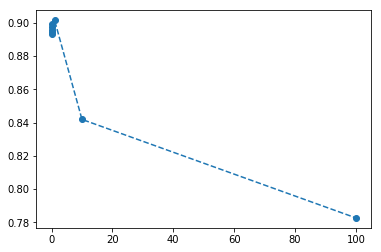

In [103]:
bow_op_alpha = apply_NB(bow_train,y_train)

In [104]:
table=PrettyTable()
table.field_names = ['Algorithm', 'Technique', 'Hyperparameter - alpha']
table.add_row(['Multinomial Naive Bayes', 'Bag Of Words', '1'])
print(table)

+-------------------------+--------------+------------------------+
|        Algorithm        |  Technique   | Hyperparameter - alpha |
+-------------------------+--------------+------------------------+
| Multinomial Naive Bayes | Bag Of Words |           1            |
+-------------------------+--------------+------------------------+


In [107]:
pred,op_NB = optimal_NB(bow_train,bow_test, y_train, bow_op_alpha, count_vect)

Negative Class Top Features:
['coffe' 'good' 'tri' 'would' 'flavor' 'one' 'product' 'like' 'tast' 'not']
********************
Positive Class Top Features:
['product' 'one' 'use' 'great' 'love' 'flavor' 'good' 'tast' 'like' 'not']


AxesSubplot(0.125,0.125;0.62x0.755)
+-----------------+--------------+----------+----------+
| Precision Score | Recall Score | f1 Score | Accuracy |
+-----------------+--------------+----------+----------+
|      0.8961     |    0.8969    |  0.8965  |  0.8969  |
+-----------------+--------------+----------+----------+


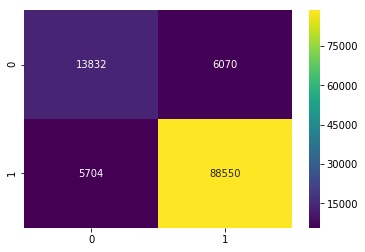

In [108]:
gen_scores(y_test,pred)

# TF_IDF - Naive Bayes

In [109]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))

In [110]:
tfidf_vect.fit(X_train.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [111]:
tfidf_train = tfidf_vect.transform(X_train.values)

In [112]:
tfidf_test = tfidf_vect.transform(X_test.values)

In [113]:
print(tfidf_train.shape)
print(tfidf_test.shape)
print(y_train.shape)
print(y_test.shape)

(250000, 2231285)
(114156, 2231285)
(250000,)
(114156,)


ALPHA : 0.000010 , Score : 0.863587
ALPHA : 0.000100 , Score : 0.877218
ALPHA : 0.001000 , Score : 0.892601
ALPHA : 0.010000 , Score : 0.896658
ALPHA : 0.100000 , Score : 0.875091
ALPHA : 1.000000 , Score : 0.782912


C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\c

ALPHA : 10.000000 , Score : 0.782763


C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ALPHA : 100.000000 , Score : 0.782763
Optimum Alpha 0.01


C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


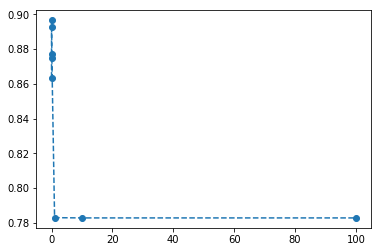

In [114]:
tfidf_op_alpha = apply_NB(tfidf_train, y_train)

It is important to note that the warnings appearing above are due to the fact that when alpha value is >= 10 the model predicts only '1' label and thus the value 0 is  being considered for the weighted average for the f1 score. A small test below provides the explanantion

In [116]:
#test cell
test_model = MultinomialNB(alpha=10)
test_model.fit(tfidf_train, y_train)
pred = test_model.predict(tfidf_test)

In [117]:
f1_score(y_test,pred,average="weighted")

C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7468137053851788

In [118]:
#test cell
# only predicts '1'
np.unique(pred)

array(['1'], dtype='<U1')

In [121]:
table=PrettyTable()
table.field_names = ['Algorithm', 'Technique', 'Hyperparameter - alpha']
table.add_row(['Multinomial Naive Bayes', 'Tf_idf', '0.01'])
print(table)

+-------------------------+-----------+------------------------+
|        Algorithm        | Technique | Hyperparameter - alpha |
+-------------------------+-----------+------------------------+
| Multinomial Naive Bayes |   Tf_idf  |          0.01          |
+-------------------------+-----------+------------------------+


In [122]:
pred,op_NB = optimal_NB(tfidf_train, tfidf_test, y_train,tfidf_op_alpha,tfidf_vect)

Negative Class Top Features:
['buy' 'tri' 'one' 'flavor' 'coffe' 'would' 'product' 'like' 'tast' 'not']
********************
Positive Class Top Features:
['use' 'coffe' 'flavor' 'not' 'good' 'like' 'tea' 'tast' 'love' 'great']


AxesSubplot(0.125,0.125;0.62x0.755)
+-----------------+--------------+----------+----------+
| Precision Score | Recall Score | f1 Score | Accuracy |
+-----------------+--------------+----------+----------+
|      0.8947     |    0.8945    |  0.8795  |  0.8945  |
+-----------------+--------------+----------+----------+


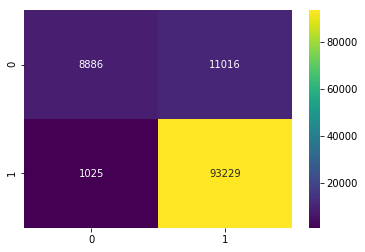

In [123]:
gen_scores(y_test,pred)

# Bernaulli Navie Bayes on Bag of Words

In [137]:
def apply_BNB(X_train, y_train):
    """accepts X_train, y_train and returns optimum alpha"""
    alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    
    cv_scores=[]
    for alpha in alpha_list:
        scores = cross_val_score(BernoulliNB(alpha=alpha), X_train, y_train, scoring= make_scorer(f1_score, average='weighted'), cv=5)
        cv_scores.append(scores.mean())
        print("ALPHA : %f , Score : %f" % (alpha,scores.mean()))
    
    op_index = cv_scores.index(max(cv_scores))
    op_alpha = alpha_list[op_index]
    print("Optimum Alpha",op_alpha)
    print(plt.plot(alpha_list,cv_scores,marker='o',linestyle="dashed"))
    return op_alpha


def optimal_BNB(X_train, X_test, y_train, op_alpha, count_vect):
    """returns prediction list and the optimal Naive Bayes model trained by using the optimal alpha value"""
    op_NB = BernoulliNB(alpha=op_alpha)
    op_NB.fit(X_train,y_train)
    pred = op_NB.predict(X_test)
    
    
    neg_class_prob_sorted =op_NB.feature_log_prob_[0, :].argsort()
    pos_class_prob_sorted =op_NB.feature_log_prob_[1, :].argsort()

    print("Negative Class Top Features:")
    print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[-10:]))
    print("*"*20)
    print("Positive Class Top Features:")
    print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-10:]))
    return pred,op_NB

ALPHA : 0.000010 , Score : 0.887696
ALPHA : 0.000100 , Score : 0.888621
ALPHA : 0.001000 , Score : 0.889975
ALPHA : 0.010000 , Score : 0.890946
ALPHA : 0.100000 , Score : 0.890022
ALPHA : 1.000000 , Score : 0.882013
ALPHA : 10.000000 , Score : 0.808045
ALPHA : 100.000000 , Score : 0.782883
Optimum Alpha 0.01


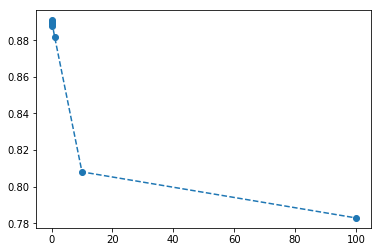

In [138]:
op_alpha = apply_BNB(bow_train,y_train)

In [139]:
pred,clf=optimal_BNB(bow_train, bow_test, y_train, op_alpha, count_vect)

Negative Class Top Features:
['buy' 'good' 'flavor' 'tri' 'would' 'one' 'product' 'like' 'tast' 'not']
********************
Positive Class Top Features:
['tri' 'use' 'one' 'flavor' 'great' 'good' 'love' 'tast' 'like' 'not']


AxesSubplot(0.125,0.125;0.62x0.755)
+-----------------+--------------+----------+----------+
| Precision Score | Recall Score | f1 Score | Accuracy |
+-----------------+--------------+----------+----------+
|      0.8837     |    0.8845    |  0.8841  |  0.8845  |
+-----------------+--------------+----------+----------+


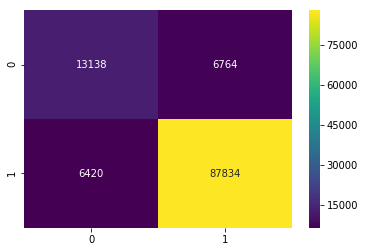

In [140]:
gen_scores(y_test,pred)

# Conclusion

In [143]:
table = PrettyTable()
table.field_names = ['','Bag of Words', 'Tf_idf', 'Bag Of Words']
table.add_row(['Algorithm', 'Multinomial NB', 'Multinomial NB', 'Bernaulli NB'])
table.add_row(['HyperParameter - alpha', '1', '0.01', '0.01'])
table.add_row(['Train - F1 Score', '90.15', '89.66', '89.09'])
table.add_row(['Test - F1 Score', '89.65', '87.95', '88.41'])
table.add_row(['Test - Precision', '89.61','89.47', '88.37'])
table.add_row(['Test - Recall', '89.69', '89.45', '88.45'])
table.add_row(['Test - Accuracy', '89.69', '89.45', '88.45'])
print(table)

+------------------------+----------------+----------------+--------------+
|                        |  Bag of Words  |     Tf_idf     | Bag Of Words |
+------------------------+----------------+----------------+--------------+
|       Algorithm        | Multinomial NB | Multinomial NB | Bernaulli NB |
| HyperParameter - alpha |       1        |      0.01      |     0.01     |
|    Train - F1 Score    |     90.15      |     89.66      |    89.09     |
|    Test - F1 Score     |     89.65      |     87.95      |    88.41     |
|    Test - Precision    |     89.61      |     89.47      |    88.37     |
|     Test - Recall      |     89.69      |     89.45      |    88.45     |
|    Test - Accuracy     |     89.69      |     89.45      |    88.45     |
+------------------------+----------------+----------------+--------------+


# Steps/Flow
*Loaded Pre-Processed data

*Sorted Data according to Time

*Splitted into (70:30) : ( Train+CV : Test) 

*Used Bag of Words and Tf_idf techniques for text processing

*F1 score was considered for hyper parameter tuning using Cross Validation

*Optimal model was built using Multinomial Naive Bayes

*Bernaulli NB was also tested for Bag of Words

*Scoring metrics were compared